In [1]:
### CBF imports #########################################
import numpy as np
import matplotlib.pyplot as plt
from data import make_rectangle, insert_shape, plot_data
from agent import Agent
from optim import cas_train_cbf, hjoint
from utils import plot_cbf
#########################################################

### HJB imports #########################################
import jax
import jax.numpy as jnp
from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import hj_reachability as hj
#########################################################

%load_ext autoreload
%autoreload 2

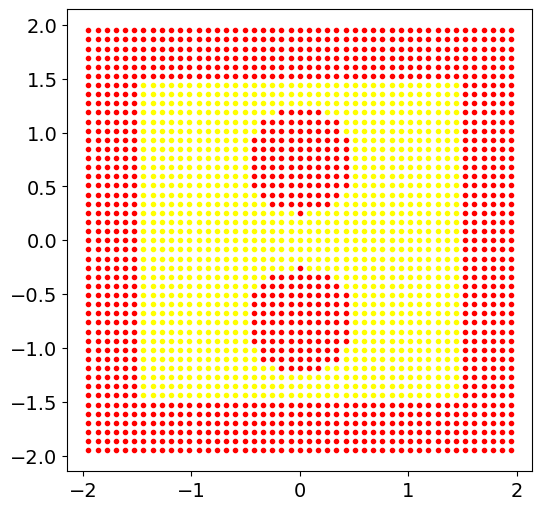

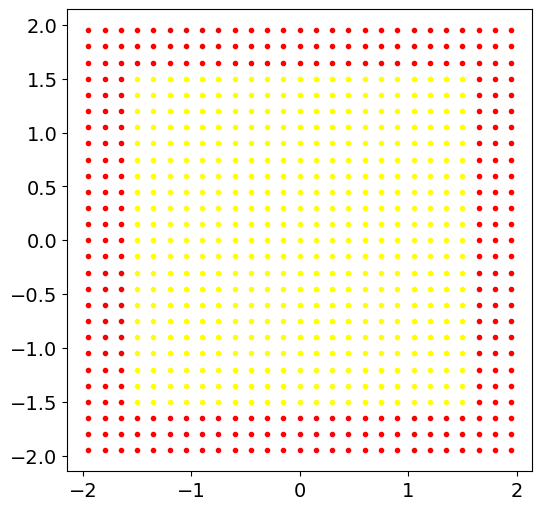

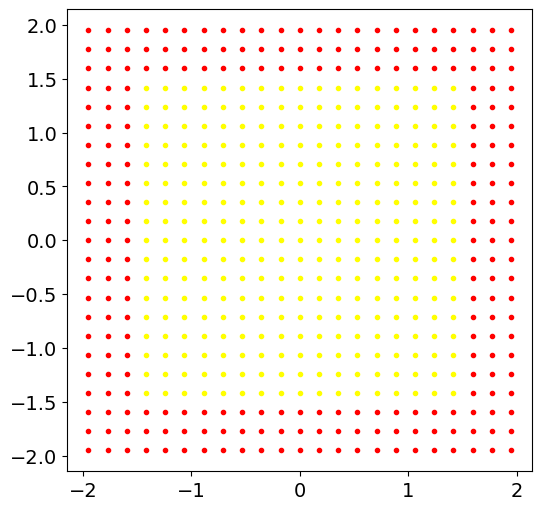

In [2]:
width=3
density = 150

### Make grid and obstacles ###
grid, params, obs_dict = make_rectangle(height=width, width=width, density=density, unsafe_margin=0.3, center=(0,0), return_params=True)
obs_dict = insert_shape(np.array([0,  0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)
obs_dict = insert_shape(np.array([0, -0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)

### Make constraints ###
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/3, unsafe_margin=0.3, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=35       , unsafe_margin=0.3, center=(0,0))

### Make HJD grid ###
lo, hi, n = params
hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n)

plot_data(grid  ,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(2209, 2)


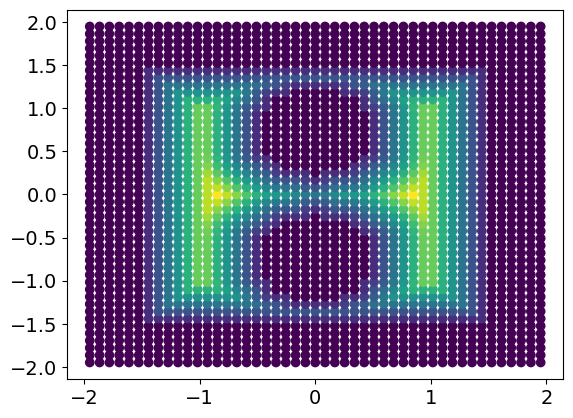

In [3]:
### Make signed distance function ###
l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])

for i in range(n[0]):
    for j in range(n[1]):
        if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j]), 3))] != 0:
            l[i, j] = 0
        else:
            l[i, j] = np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j], axis=1))

print(grid.shape)
plt.scatter(grid[:,0], grid[:,1], c=l.reshape(-1, 1))
plt.show()

In [4]:
l = jnp.array(l)
values = l
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
dynamics = hj.systems.Planar()
#next: need to define own dynamics, using air3d on 2d grid (w/out periodic dim) causes shape mismatch
time = 0.
target_time = -50
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|###############################################################################################################################################| 50.0000/50.0 [00:01<00:00, 29.72sim_s/s]


<Figure size 640x480 with 0 Axes>

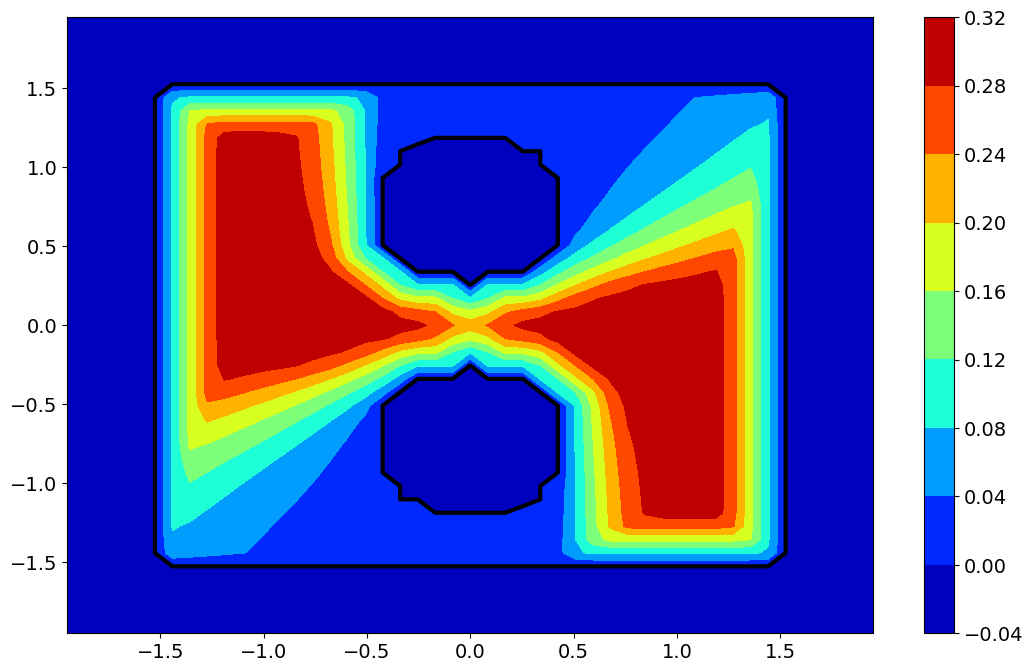

In [6]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :].T)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [7]:
times = np.linspace(0, -50, 100)
initial_values = values
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|###############################################################################################################################################| 50.0000/50.0 [00:01<00:00, 29.97sim_s/s]


In [8]:
vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :].T,
                levels=0,
                colors="black",
                linewidths=3)


render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [ ]:
a = Agent((0, 0), grid, obs_dict, width=width, sensor_radius=1)

scan_safe, scan_unsafe = a.scan()
rx = 1.5
samples  = a.sample(rx, grid=s_grid)

if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: 
    x_unsafe = samples

n_safe = scan_safe.shape[0]
# prev (0.2, 0.50)
x_buffer, x_safe = a.make_buffer(scan_safe, int(0.2 * n_safe), 0.60)

rc = 1
C = []
for x in c_grid:
    if np.linalg.norm(x - a.pos) <= rc:
        C.append(x)
C = np.array(C)
a.centers.append(C)

In [ ]:
plot_data(grid, obs_dict, [(x_safe  , "cyan"), 
                           (x_buffer, "blue"), 
                           (x_unsafe, "red"),
                           (C       , "green")])

In [ ]:
theta_max=10
max_elem =100
gamma_safe=0.3
gamma_unsafe=-0.3
gamma_dyn=0.1
theta=cas_train_cbf(x_safe, x_buffer, x_unsafe, C, theta_max, max_elem, rx, rc, gamma_safe, gamma_unsafe, gamma_dyn)
a.thetas.append(theta)

In [ ]:
plot_cbf(a.width, a.thetas, a.centers)

In [ ]:
pos = 0
neg = 0
for elem in theta:
    if elem < 0:
        neg += elem
    else:
        pos += elem
print(neg/pos)

In [ ]:
a.pos = np.array([0, 0])
a.t   = 0
tol   = 1
for i in range(30):
    prev_pos = a.pos  
    while np.linalg.norm(a.pos - prev_pos) <= 0.50:
        target=a.width*np.random.rand(2) - a.width/2
        while hjoint(target, a.thetas, a.centers) > 0:
            target=a.width*np.random.rand(2) - a.width/2
        print("target:", target) 
        a.goto(target, T=3, tend=500, tol=tol) 
        print("dx:", np.linalg.norm(a.pos - prev_pos))
 
    '''
    first=True
    while hjoint(a.pos, a.thetas, a.centers) >= 1 or first:
        a.goto(target, T=7, tend=150, tol=tol)
        first = False
    '''
        
    scan_safe, scan_unsafe = a.scan()
    rx = 1.5
    samples  = a.sample(rx, grid=s_grid) 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples 
    n_safe = scan_safe.shape[0]
    x_buffer, x_safe = a.make_buffer(scan_safe, int(0.2 * n_safe), 0.50) 
    rc = 1
    C  = []
    for x in c_grid:
        if np.linalg.norm(x - a.pos) <= rc:
            C.append(x)
    C = np.array(C)
    a.centers.append(C)
    plot_data(grid, obs_dict, [(x_safe  , "cyan"), 
                               (x_buffer, "blue"), 
                               (x_unsafe, "red"),
                               (C       , "green")])
    theta=cas_train_cbf(x_safe, x_buffer, x_unsafe, C, theta_max, max_elem, rx, rc, gamma_safe, gamma_unsafe, gamma_dyn)
    a.thetas.append(theta)
    plot_cbf(a.width, a.thetas, a.centers)